In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("../data/car-price.csv")

In [3]:
columns = ["Make", "Model", "Year", "Engine HP", "Engine Cylinders", "Transmission Type", "Vehicle Style", "highway MPG", "city mpg", "MSRP"]
df = df[columns]

In [4]:
df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [5]:
df.columns = df.columns.str.replace(" ", "_").str.lower()

In [6]:
print(df.isna().sum().sum())
df = df.fillna(0)
print(df.isna().sum().sum())

99
0


In [7]:
df['above_average'] = df['msrp'] > df['msrp'].mean()

In [8]:
df['above_average']

0         True
1         True
2        False
3        False
4        False
         ...  
11909     True
11910     True
11911     True
11912     True
11913    False
Name: above_average, Length: 11914, dtype: bool

In [9]:
df.drop("msrp", axis=1, inplace=True)
X = df.copy()
y = X.pop('above_average')

In [19]:
from sklearn.model_selection import train_test_split

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

In [20]:
from sklearn.metrics import roc_auc_score

feature_auc = {}

for numerical_feature in df.select_dtypes('number'):
    auc = roc_auc_score(y_train, X_train[numerical_feature])
    feature_auc[numerical_feature] = auc

In [21]:
pd.DataFrame.from_dict(feature_auc, orient='index').sort_values(by=0)

,0
city_mpg,0.326576
highway_mpg,0.366941
year,0.687551
engine_cylinders,0.766116
engine_hp,0.917103


In [22]:
from sklearn.feature_extraction import DictVectorizer

train_dict = X_train.to_dict(orient='records')
dv = DictVectorizer()
dv.fit(train_dict)

DictVectorizer()

In [23]:
X_train_dict = dv.transform(train_dict)

In [24]:
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [25]:
estimator.fit(X_train_dict, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [26]:
X_valid_dict = dv.transform(X_valid.to_dict(orient='records'))
valid_preds = estimator.predict_proba(X_valid_dict)[:, 1]

In [28]:
valid_score = roc_auc_score(y_valid, valid_preds)
print(f"{valid_score:.4f}")

0.9797


In [60]:
thresholds = np.arange(0.0, 1.0, 0.01)
precision = np.zeros_like(thresholds)
recall = np.zeros_like(thresholds)

for i, threshold in enumerate(thresholds):
   y_preds = valid_preds > threshold 
   predict_positive = y_preds == 1
   predict_negative = y_preds == 0

   actual_positive = y_valid == 1
   actual_negative = y_valid == 0
   
   tps = (predict_positive & actual_positive).sum()
   fps = (predict_positive & actual_negative).sum()
   tns = (predict_negative & actual_negative).sum()
   fns = (predict_negative & actual_positive).sum()

   precision[i] = tps / (tps + fps)
   recall[i] = tps / (tps + fns)

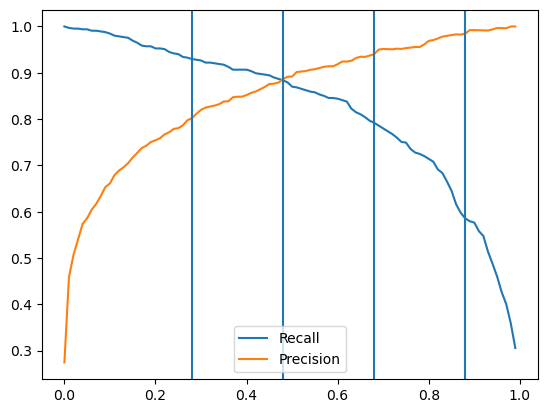

In [61]:
fig, ax = plt.subplots()

ax.plot(thresholds, recall, label='Recall')
ax.plot(thresholds, precision, label='Precision')
ax.axvline(x=0.28)
ax.axvline(x=0.48)
ax.axvline(x=0.68)
ax.axvline(x=0.88)

plt.legend()
plt.show()

In [67]:
f1 = 2 * precision * recall / (precision + recall)
thresholds[f1.argmax()]


0.49

In [69]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=1)

In [76]:

for C in [0.01, 0.1, 0.5, 10]:
    scores = []

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X_full_train, y_full_train)):
        X_train = X_full_train.iloc[train_idx]
        y_train = y_full_train.iloc[train_idx]
    
        X_valid = X_full_train.iloc[valid_idx]
        y_valid = y_full_train.iloc[valid_idx]
        
        train_dict = X_train.to_dict(orient='records')
        valid_dict = X_valid.to_dict(orient='records')
    
        dv = DictVectorizer()
        dv.fit(train_dict)
        
        X_train_dict = dv.transform(train_dict)
        X_valid_dict = dv.transform(valid_dict)
        
        estimator = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        
        estimator.fit(X_train_dict, y_train)
        valid_preds = estimator.predict_proba(X_valid_dict)[:, 1]
        
        scores.append(roc_auc_score(y_valid, valid_preds))
    print(f"C={C}, score = {np.mean(scores)} \pm {np.std(scores)}")    

C=0.01, score = 0.9516232719893825 \pm 0.002533538664405695
C=0.1, score = 0.9717986426078367 \pm 0.0015904615088676397
C=0.5, score = 0.9769353522100491 \pm 0.0016199663363669601
C=10, score = 0.9813388673239005 \pm 0.0032641124348568875


In [74]:
np.std(scores)

0.002060199182252492